In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os


In [11]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Dataset

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Dataset


In [12]:
!ls

test1  train1


In [13]:
# Hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 224  # GoogLeNet typically uses 224x224 input size
CHANNELS = 3
EPOCHS = 50
n_classes = 5

In [14]:
# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5034 files belonging to 5 classes.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 1162 files belonging to 5 classes.


In [16]:
class_names = train_ds.class_names

# Prefetch datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [17]:
# Define the Inception module
def inception_module(x, f1, f3_r, f3, f5_r, f5, pool_proj):
    conv1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    conv3 = layers.Conv2D(f3_r, (1, 1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3)

    conv5 = layers.Conv2D(f5_r, (1, 1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5)

    pool_proj_layer = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj_layer = layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(pool_proj_layer)

    output = layers.concatenate([conv1, conv3, conv5, pool_proj_layer], axis=-1)
    return output

In [18]:
# Build the GoogLeNet-inspired model
input_layer = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 64, 96, 128, 16, 32, 32)
x = inception_module(x, 128, 128, 192, 32, 96, 64)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 192, 96, 208, 16, 48, 64)
x = inception_module(x, 160, 112, 224, 24, 64, 64)
x = inception_module(x, 128, 128, 256, 24, 64, 64)
x = inception_module(x, 112, 144, 288, 32, 64, 64)
x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 256, 160, 320, 48, 128, 128)
x = inception_module(x, 384, 192, 384, 48, 128, 128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output_layer = layers.Dense(n_classes, activation='softmax')(x)


In [19]:
model = models.Model(input_layer, output_layer)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [20]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 192)    │        110,784 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 192)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 96)     │         18,528 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 16)     │          3,088 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 192)    │              0 │ max_pooling2d_1[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 64)     │         12,352 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 128)    │        110,720 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 32)     │         12,832 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 32)     │          6,176 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 256)    │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 28, 28, 128)    │         32,896 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 28, 28, 32)     │          8,224 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 6,043,205 (23.05 MB)

 Trainable params: 6,043,205 (23.05 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1266s 2s/step - accuracy: 0.2064 - loss: 1.7186 - val_accuracy: 0.2229 - val_loss: 1.6044
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.2448 - loss: 1.6046 - val_accuracy: 0.1859 - val_loss: 1.6347
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.2407 - loss: 1.5971 - val_accuracy: 0.1867 - val_loss: 1.6248
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.3489 - loss: 1.3892 - val_accuracy: 0.5637 - val_loss: 0.8430
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.5668 - loss: 0.8654 - val_accuracy: 0.6239 - val_loss: 0.6923
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.6195 - loss: 0.7284 - val_accuracy: 0.7177 - val_loss: 0.6313
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.6582 - loss: 0.6805 - val_accuracy: 0.6954 - val_loss: 0.6136
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.6785 - loss: 0.

In [22]:
# Evaluate the model on the test set
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9533 - loss: 0.1436
Test Accuracy: 94.75%


In [23]:
# Plot training accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

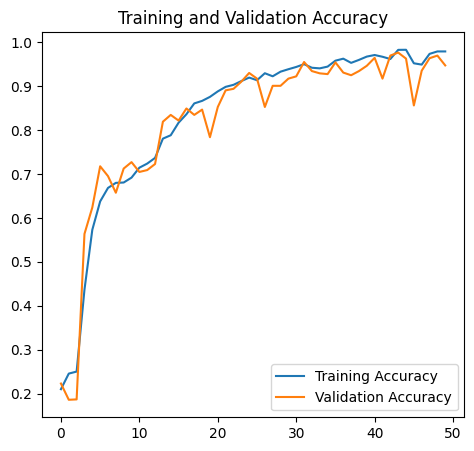

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

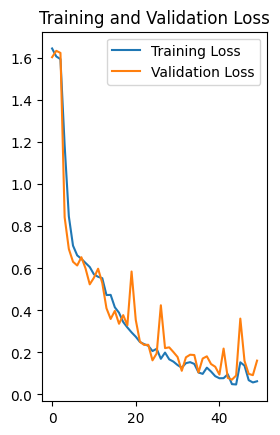

In [25]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: up curl (98.92%)


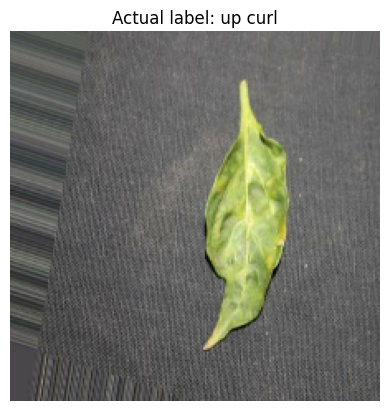

In [26]:
# Display first image prediction from test set
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    plt.title(f"Actual label: {class_names[first_label]}")
    plt.axis('off')

    # Predict the batch
    batch_prediction = model.predict(images_batch)
    predicted_class_idx = np.argmax(batch_prediction[0])
    predicted_class_name = class_names[predicted_class_idx]
    confidence = batch_prediction[0][predicted_class_idx]

    print(f"Predicted label: {predicted_class_name} ({confidence * 100:.2f}%)")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

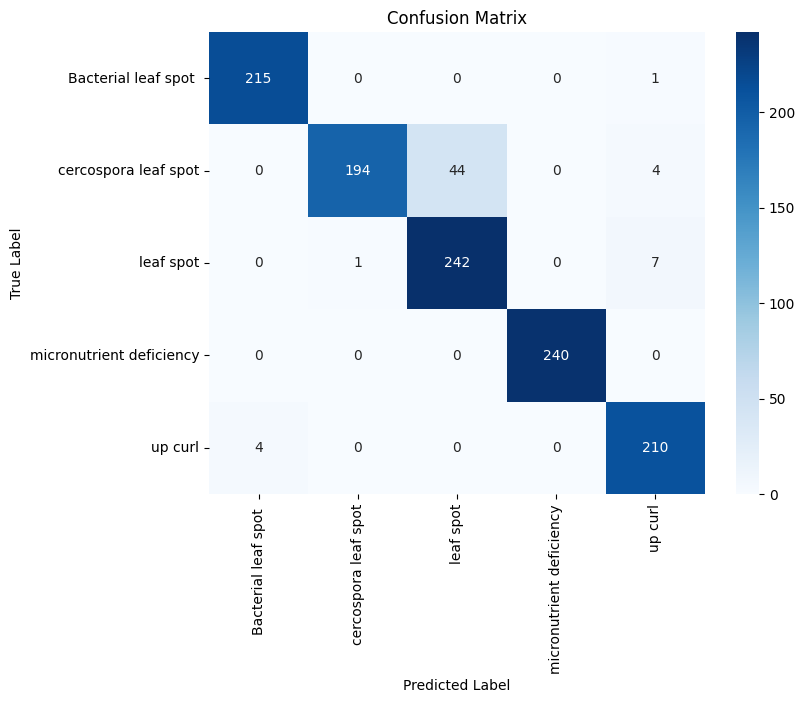

                          precision    recall  f1-score   support

    Bacterial leaf spot        0.98      1.00      0.99       216
    cercospora leaf spot       0.99      0.80      0.89       242
               leaf spot       0.85      0.97      0.90       250
micronutrient deficiency       1.00      1.00      1.00       240
                 up curl       0.95      0.98      0.96       214

                accuracy                           0.95      1162
               macro avg       0.95      0.95      0.95      1162
            weighted avg       0.95      0.95      0.95      1162



In [27]:
# Confusion matrix and classification report
y_true = []
y_pred = []
for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=-1))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

In [28]:
# Save the model
model.save("chilli.h5")

In [29]:
def preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to match input size for the model
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    return img_array


In [30]:
def predict_image(img):
    img_array = preprocess_image(img)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

In [31]:
def select_image():
    global img_label, img_path
    img_path = filedialog.askopenfilename()
    if img_path:
        img = Image.open(img_path)
        img = img.resize((224, 224))  # Resize for display
        img_tk = ImageTk.PhotoImage(img)
        img_label.config(image=img_tk)
        img_label.image = img_tk

In [37]:
import tensorflow as tf
from PIL import Image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from io import BytesIO
uploaded = files.upload()

Saving WhatsApp Image 2024-10-30 at 16.04.52_28b14269.jpg to WhatsApp Image 2024-10-30 at 16.04.52_28b14269.jpg


In [38]:
def preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Ensure this matches the training size
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Check pixel value ranges, ensure they match training normalization
    print(f"Image array before normalization: {img_array.min()}, {img_array.max()}")

    img_array = tf.expand_dims(img_array, 0)  # Add batch axis
    return img_array

def predict_image(img_path):
    img_array = preprocess_image(img_path)

    # Predict the class
    predictions = model.predict(img_array)

    # Output raw predictions to see confidence for each class
    print(f"Raw model predictions: {predictions}")

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    # Display confidence and predicted class
    print(f"Predicted Class: {predicted_class}")
    print(f"Prediction Confidence: {confidence}%")

    return predicted_class, confidence


In [39]:
for fn in uploaded.keys():
    img_path = fn

In [40]:

predicted_class, confidence = predict_image(img_path)
print(class_names)



Image array before normalization: 0.0, 255.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Raw model predictions: [[1.20645400e-05 2.61176757e-18 2.47670357e-07 9.99987721e-01
  1.04549716e-10]]
Predicted Class: micronutrient deficiency
Prediction Confidence: 100.0%
['Bacterial leaf spot ', 'cercospora leaf spot', 'leaf spot', 'micronutrient deficiency', 'up curl']


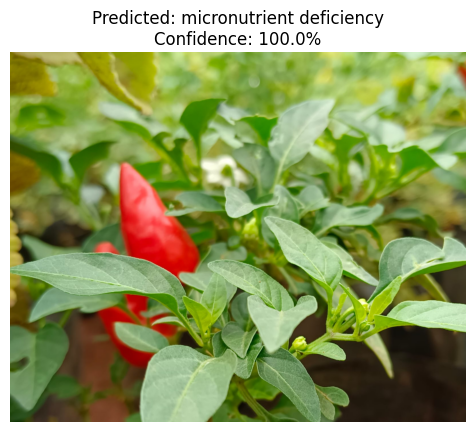

In [41]:
img = Image.open(img_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
plt.axis('off')
plt.show()